/tmp/ipykernel_19/3157872080.py:108: RuntimeWarning: divide by zero encountered in divide
  cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)
/tmp/ipykernel_19/3157872080.py:111: RuntimeWarning: invalid value encountered in divide
  cosmic_ray = cosmic_ray / cosmic_ray.max()


  Spectrum_ID  Wavelength Intensity_Type  Intensity
0  Spectrum_1   -1.000000  Full_Spectrum   1.966685
1  Spectrum_1   -0.998045  Full_Spectrum   1.817492
2  Spectrum_1   -0.996090  Full_Spectrum   1.471102
3  Spectrum_1   -0.994135  Full_Spectrum   1.410646
4  Spectrum_1   -0.992180  Full_Spectrum   1.364302


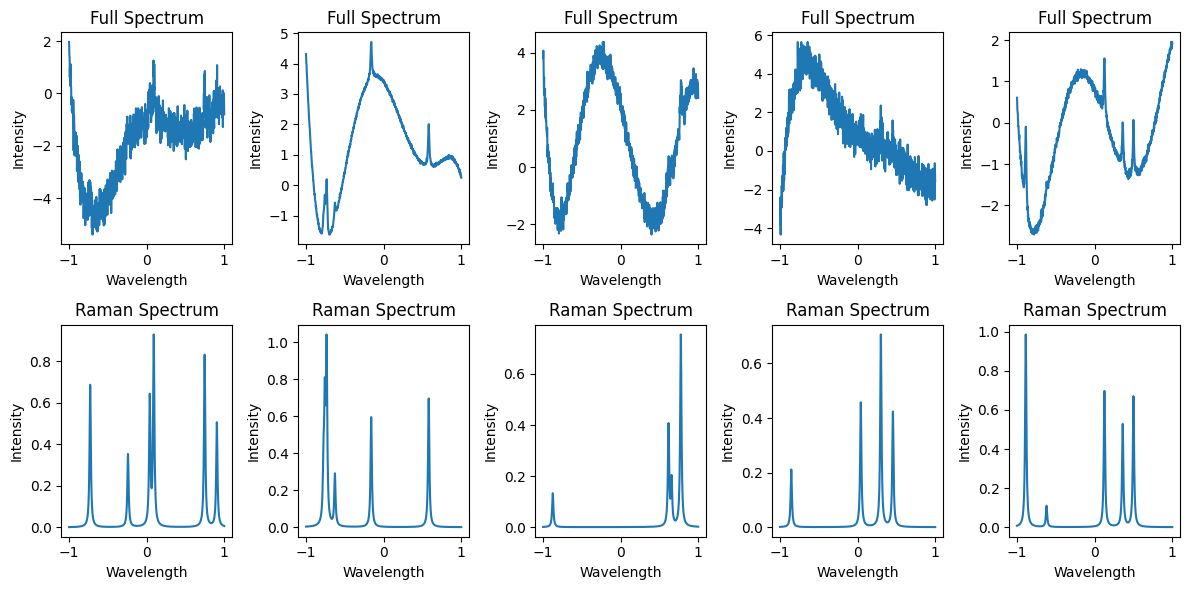

In [1]:
# PLEASE BE OK FUCKING CODE!!!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list = []

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
     
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store the Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    # Generate Cosmic Rays 
    # Lorentzian peak with a width of 0, y = 1 / (x - position)^2  
    # Cosmic ray amplitudes: randomized between 0.8 & L2-norm of complete signal

    def add_cosmic_rays(self, num_cosmic_rays):
        cosmic_rays_spectrum = self.noisy_peaky_cheby.copy()
    
        # Calculate L2-norm of complete signal
        l2_norm = np.linalg.norm(cosmic_rays_spectrum)
    
        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 and the L2-norm of the complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, l2_norm)
        
            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))
        
            # Create cosmic ray using y = 1 / (x - position)^2  
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)

            # Normalize cosmic ray
            cosmic_ray = cosmic_ray / cosmic_ray.max()

            # Add cosmic ray to spectrum
            cosmic_rays_spectrum += cosmic_ray

        # Update full synthetic spectrum with cosmic rays
        full_spectrum = cosmic_rays_spectrum + self.noisy_peaky_cheby
        self.full_spectra_list.append(full_spectrum)

        # Update the Raman spectrum (only peaks)
        raman_spectrum = self.peaks
        self.raman_spectra_list.append(raman_spectrum)

    def save_to_csv(self, filename='synthetic_spectra.csv'):
        # Create a list to store individual spectra as dictionaries
        spectra_data = []

        for i, (full_spectrum, raman_spectrum) in enumerate(zip(self.full_spectra_list, self.raman_spectra_list), start=1):
            # Create a dictionary for each data point in a spectrum
            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, full_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Full_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, raman_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Raman_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

        # Convert the list of dictionaries to a DataFrame
        df = pd.DataFrame(spectra_data)

        # Save DataFrame to CSV file
        df.to_csv(filename, index=False)

        return df


# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 0.1
num_spectra = 5

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    
    # Generate a random number of cosmic rays between 0 and 5
    num_cosmic_rays = np.random.randint(0, 6)
    synthetic_data_generator.add_cosmic_rays(num_cosmic_rays)

# Save X and Y values to CSV
output_file_path = 'synthetic_spectra.csv'
df = synthetic_data_generator.save_to_csv(filename=output_file_path)

# Display the DataFrame
print(df.head())

# Visualize results
plt.figure(figsize=(12, 6))

num_plots = min(5, num_spectra)

# Plot full synthetic spectra
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title('Full Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot Raman spectra
for i in range(num_plots):
    plt.subplot(2, num_plots, i + num_plots + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.raman_spectra_list[i])
    plt.title('Raman Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

plt.tight_layout()
plt.show()

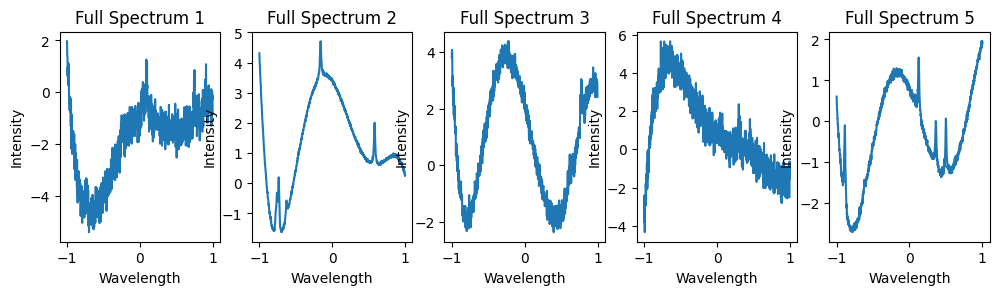

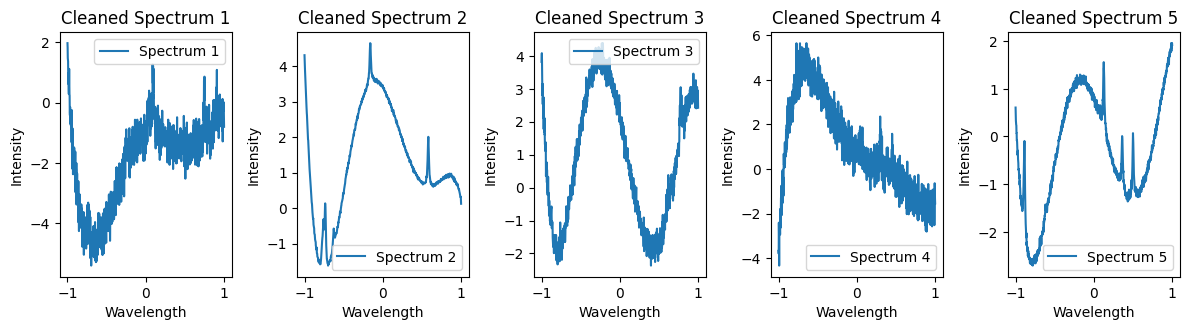

In [2]:
# CLEAN RAYS
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Read synthetic spectra from the CSV file
file_path = 'synthetic_spectra.csv'
data = pd.read_csv(file_path)

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = data[data['Spectrum_ID'] == spectrum_id]

    # Check if the spectrum exists in the data
    if not spectrum_data.empty:

        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(data[data['Intensity_Type'] == 'Full_Spectrum']['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 0.2
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # 3) Replace these points using linear interpolation from neighboring data points
        for index in cosmic_ray_indices:
            if index - 1 >= 0 and index + 1 < len(data):  # index must be within a valid range
                left_neighbor = data.at[index - 1, 'Intensity']
                right_neighbor = data.at[index + 1, 'Intensity']

                # Linear interpolation to replace cosmic ray spike
                interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
                data.at[index, 'Intensity'] = interpolated_value

                         
        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the cleaned spectrum to the list
        cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create the output directory if it doesn't exist
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame with a specific filename
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Plot full synthetic spectra
plt.figure(figsize=(12, 6))  # Create a figure to hold the subplots

for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i])
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot cleaned Raman spectra
plt.figure(figsize=(12, 6))  # Create a new figure for cleaned spectra

for i, spectrum_data in enumerate(cleaned_spectra):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()